# POGZ and Associated Syndrome


[White-Sutton syndrome](https://omim.org/entry/616364) is a neurodevelopmental disorder caused by pathogenic variants in the [POGZ](https://omim.org/entry/614787) gene.

<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

One/Two/Several previous publications have reported candidate genotype-phenotype correlations in [Syndrome Name].

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Negy et al. (2022)](https://pubmed.ncbi.nlm.nih.gov/35052493/) summarized data on 117 individuals with White-Sutton syndrome, including 12 novel individuals. They wrote:

> A severity scoring system was developed for the comparison. Mild and severe phenotypes were compared with the types and location of the variants and the predicted presence or absence of nonsense-mediated RNA decay (NMD). Missense variants were more often associated with mild phenotypes (p = 0.0421) and truncating variants predicted to escape NMD presented with more severe phenotypes (p < 0.0001). Within this group, variants in the prolin-rich region of the POGZ protein were associated with the most severe phenotypes (p = 0.0004).

These authors did not apply multiple testing correction.


In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using genophenocorr version 0.9.4


# POGZ
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for POGZ.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'POGZ'
mane_tx_id = 'NM_015100.4'
mane_protein_id = "NP_055915.2"
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.24'  
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets (
   phenopackets=phenopackets, 
   cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals from {gene_symbol}')
qc.summarize()

Individuals Processed: 100%|██████████| 117/117 [00:02<00:00, 42.03 individuals/s]
Loaded 117 individuals from POGZ
Validated under permissive policy
No errors or warnings were found


## Define Configuration & Run Analysis

In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
97,Delayed speech and language development
85,Global developmental delay
84,Intellectual disability
80,Delayed gross motor development
49,Microcephaly
48,Autistic behavior
33,Feeding difficulties
26,Reduced social responsiveness
25,Hypertelorism
23,Midface retrusion


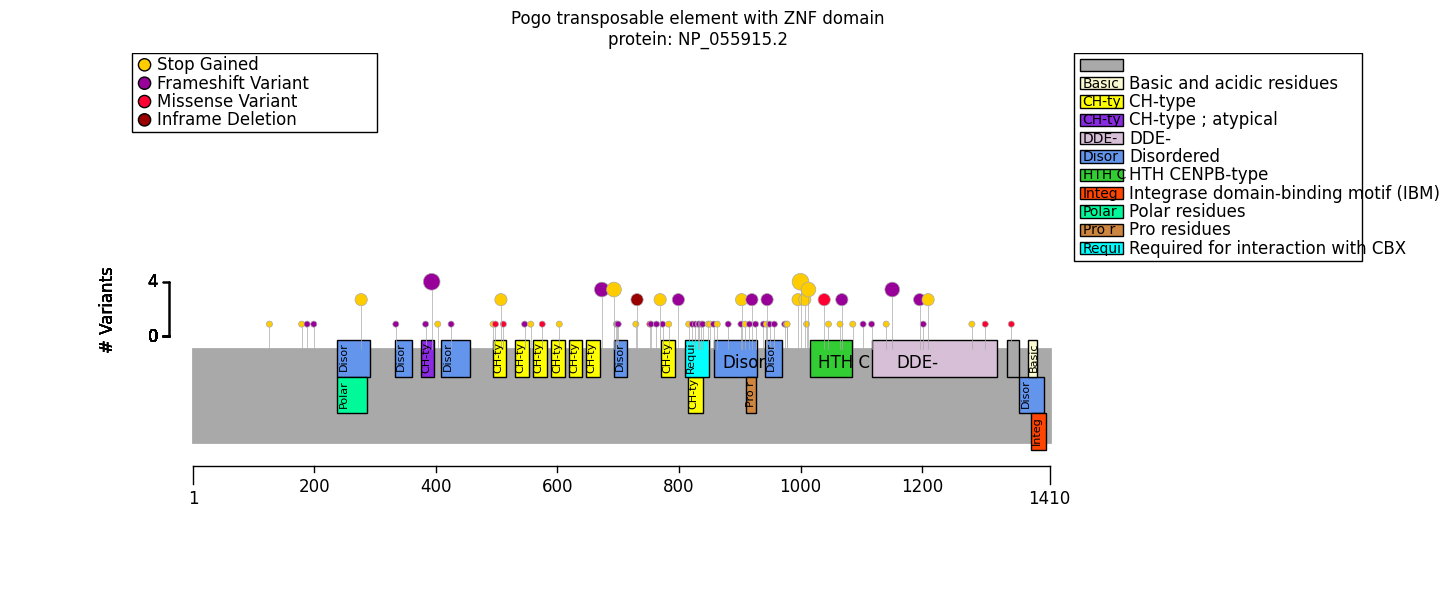

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

pogz_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
pogz_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
2,Disordered,Region,239 - 291,p.Ser278Ter
2,Polar residues,Compositional bias,239 - 286,p.Ser278Ter
1,Disordered,Region,333 - 361,p.Pro336GlnfsTer23
5,C2H2-type 1; atypical,Zinc finger,376 - 397,p.Met394ValfsTer9; p.Arg385SerfsTer4
1,Disordered,Region,410 - 456,p.Glu427Ter
5,C2H2-type 2,Zinc finger,495 - 516,p.Arg508Ter; p.His512Asn; p.Cys499Phe; p.Arg495Ter
1,C2H2-type 3,Zinc finger,531 - 553,p.Cys547Ter
1,C2H2-type 4,Zinc finger,561 - 583,p.Leu576Pro
1,C2H2-type 5,Zinc finger,591 - 613,p.Glu604Ter
0,C2H2-type 6,Zinc finger,620 - 641,


In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
4,1_151424958_151424960_CAT_C,c.1180_1181del (p.Met394ValfsTer9),8,frameshift
4,1_151406034_151406034_G_A,c.3001C>T (p.Arg1001Ter),19,stop gained
3,1_151408734_151408735_CG_C,c.2020del (p.Arg674ValfsTer9),13,frameshift
3,SO:1000029_HGNC:18801_POGZ,SV involving POGZ (p.?),,chromosomal deletion
3,1_151408563_151408563_G_A,c.2080C>T (p.Arg694Ter),14,stop gained
3,1_151405577_151405579_CCT_C,c.3456_3457del (p.Glu1154ThrfsTer4),19,frameshift
2,1_151405917_151405917_C_T,c.3118G>A (p.Glu1040Lys),19,missense
2,1_151405827_151405829_CAT_C,c.3206_3207del (p.Tyr1069Ter),19,frameshift
2,1_151408165_151408165_G_C,c.2310C>G (p.Tyr770Ter),15,stop gained
2,1_151423950_151423950_G_A,c.1522C>T (p.Arg508Ter),9,"stop gained, splice region"


## Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)
missense_result =  analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,28
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,68
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,215


In [10]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, missense_result)

Allele group,Missense,Other,Corrected p values,p values
Global developmental delay [HP:0001263],7/8 (88%),78/78 (100%),1.0,0.093023
Delayed speech and language development [HP:0000750],8/9 (89%),89/92 (97%),1.0,0.315649
Delayed gross motor development [HP:0002194],6/7 (86%),74/80 (92%),1.0,0.456354
Autistic behavior [HP:0000729],4/4 (100%),44/59 (75%),1.0,0.564453
Microcephaly [HP:0000252],1/3 (33%),48/86 (56%),1.0,0.585784
Decreased head circumference [HP:0040195],1/1 (100%),48/48 (100%),1.0,1.000000
Aplasia/Hypoplasia of the cerebrum [HP:0007364],1/1 (100%),49/49 (100%),1.0,1.000000
Neurodevelopmental abnormality [HP:0012759],10/10 (100%),105/105 (100%),1.0,1.000000
Feeding difficulties [HP:0011968],2/2 (100%),31/46 (67%),1.0,1.000000
Abnormal cerebral morphology [HP:0002060],2/2 (100%),50/50 (100%),1.0,1.000000


In [11]:
from severity_score import PogzSeverityScorer
from gpsea.analysis.pscore import DeVriesPhenotypeScorer
from gpsea.analysis.pscore.stats import MannWhitneyStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis

devries_scorer = DeVriesPhenotypeScorer(hpo)
pogz_severity_scorer = PogzSeverityScorer(hpo)

score_statistic = MannWhitneyStatistic()
score_analysis = PhenotypeScoreAnalysis(
    score_statistic=score_statistic,
)
missense_pogz_severity_result = score_analysis.compare_genotype_vs_phenotype_score(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_scorer=pogz_severity_scorer,
)

missense_devries_severity_result = score_analysis.compare_genotype_vs_phenotype_score(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_scorer=devries_scorer,
)

print(f"POGZ severity score, missense, p-value={missense_pogz_severity_result.pval:.5f}")
print(f"DeVries score, missense, p-value={missense_devries_severity_result.pval:.5f}")

POGZ severity score, missense, p-value=0.42914
DeVries score, missense, p-value=0.42914


In [12]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect

is_frameshift = variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
frameshift_clf = monoallelic_classifier(
    a_predicate=is_frameshift,
    b_predicate=~is_frameshift,
    a_label="Frameshift",
    b_label="Other"
)
fs_result =  analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=frameshift_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, fs_result)


Allele group,Frameshift,Other,Corrected p values,p values
Intellectual disability [HP:0001249],37/40 (92%),47/47 (100%),1.0,0.093212
Sensorineural hearing impairment [HP:0000407],12/29 (41%),11/36 (31%),1.0,0.438013
Autistic behavior [HP:0000729],18/25 (72%),30/38 (79%),1.0,0.557972
Delayed speech and language development [HP:0000750],42/43 (98%),55/58 (95%),1.0,0.634414
Microcephaly [HP:0000252],24/41 (59%),25/48 (52%),1.0,0.669455
Delayed gross motor development [HP:0002194],34/38 (89%),46/49 (94%),1.0,0.694117
Feeding difficulties [HP:0011968],14/21 (67%),19/27 (70%),1.0,1.000000
Diagnostic behavioral phenotype [HP:0025783],18/18 (100%),30/30 (100%),1.0,1.000000
Decreased head circumference [HP:0040195],24/24 (100%),25/25 (100%),1.0,1.000000
Aplasia/Hypoplasia of the cerebrum [HP:0007364],25/25 (100%),25/25 (100%),1.0,1.000000


# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

FET_results = (
   GPAnalysisResultSummary.from_multi(
        result=missense_result,
    
    ),
    GPAnalysisResultSummary.from_multi(
        result=fs_result,
    ),
)

m_results = (
    GPAnalysisResultSummary.from_mono(result=missense_pogz_severity_result),
     GPAnalysisResultSummary.from_mono(result=missense_devries_severity_result),
)


caption ="""Negy et al. (2022) summarized data on 117 individuals with White-Sutton syndrome. They identified a correlation 
between a severity score and nonsense-mediated RNA decay (NMD). Missense variants were more often associated with mild phenotypes 
and truncating variants predicted to escape NMD presented with more severe phenotypes. Within this group, variants in the 
proline-rich region of the POGZ protein were associated with the most severe phenotypes).
 These authors did not apply multiple testing correction \\cite{PMID_35052493}.
Our analysis did not identify a significant GPC."""

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=FET_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)



In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=pogz_fig)

Figure saved to ../../supplement/img/POGZ_protein_diagram-draft.pdf
Output to ../../supplement/tex/POGZ_summary_draft.tex
